In [52]:
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from matplotlib import colors
import elevation

In [53]:
import os

# bbox=(-103.2250, 30.351757, -103.1612, 30.447701)
bbox=(-103.31498383879455, 30.275977600526915, -103.1612, 30.447701)
west, south, east, north = bbox
west, south, east, north = bbox = west - .05, south - .05, east + .05, north + .05

dem_path = '/ranch.tif'
output = os.getcwd() + dem_path

elevation.clip(bounds=bbox, output=output, product='SRTM3')
print('downloaded')
grid = Grid.from_raster(output)
dem = grid.read_raster(output)
print('loaded')

/Users/vulcan/Library/Caches/elevation/SRTM3
make: Nothing to be done for `download'.
/Users/vulcan/Library/Caches/elevation/SRTM3
make: Nothing to be done for `all'.
/Users/vulcan/Library/Caches/elevation/SRTM3
cp SRTM3.vrt SRTM3.c0ff59da3c714c3fb22dbc5f46d1bca4.vrt
/Users/vulcan/Library/Caches/elevation/SRTM3
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -103.36498383879454 30.497701 -103.1112 30.225977600526914 SRTM3.c0ff59da3c714c3fb22dbc5f46d1bca4.vrt /Users/vulcan/Documents/sjsu/2023/CMPE-195A/project/argus/backend/notebooks/ranch.tif
rm -f SRTM3.c0ff59da3c714c3fb22dbc5f46d1bca4.vrt
downloaded
loaded


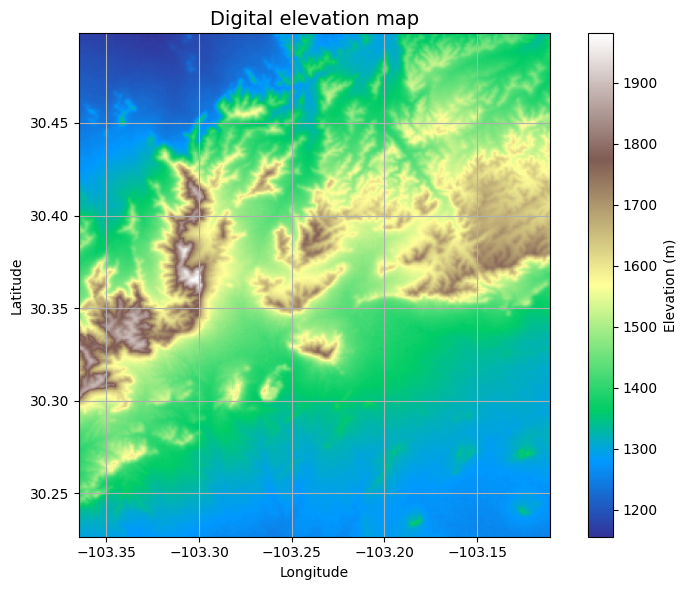

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap="terrain", zorder=1)
plt.colorbar(label="Elevation (m)")
plt.grid(zorder=0)
plt.title("Digital elevation map", size=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

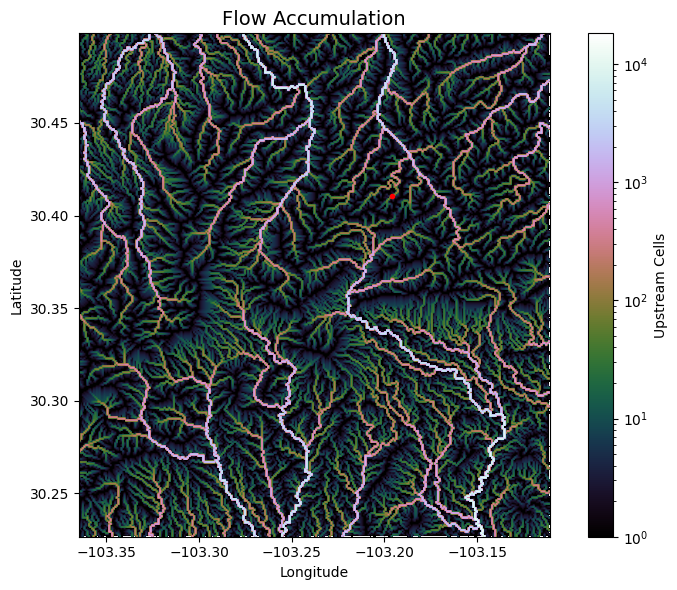

In [55]:
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
im = ax.imshow(
    acc,
    extent=grid.extent,
    zorder=2,
    cmap="cubehelix",
    norm=colors.LogNorm(1, acc.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells")
plt.title("Flow Accumulation", size=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot(
    -103.19616199070633, 30.4102907999941, 'ro', markersize=3,
)
plt.tight_layout()
plt.show()

In [37]:
# def find_watershed(grid, x, y):
#     # Delineate a catchment
#     # ---------------------
#     # Specify pour point
#     # Snap pour point to high accumulation cell
#     x_snap, y_snap = grid.snap_to_mask(acc >500, (x, y))
    
#     # Delineate the catchment
#     catch = grid.catchment(
#         x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype="coordinate",
#     )

#     setattr(catch, 'x', x_snap)
#     setattr(catch, 'y', y_snap)

#     return catch

30.30916666666667 -103.26916666666666


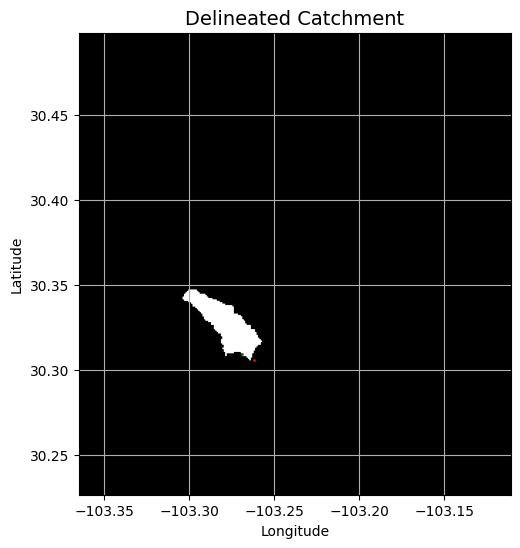

In [78]:
def find_watershed(grid, x, y):
    # Delineate a catchment
    # ---------------------
    # Specify pour point
    # Snap pour point to high accumulation cell
    x_snap, y_snap = grid.snap_to_mask(acc > 500, (x, y))
    
    # Delineate the catchment
    catch = grid.catchment(
        x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype="coordinate",
    )

    setattr(catch, 'x', x_snap)
    setattr(catch, 'y', y_snap)

    return catch
coords = (-103.26181172713814,30.30603027228133)
catch = find_watershed(grid, *coords)

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
# grid.clip_to(catch)
# clipped_catch = grid.view(catch)

# Plot the catchment
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.grid("on", zorder=0)
im = ax.imshow(
    catch,
    # np.where(clipped_catch, clipped_catch, np.nan),
    extent=grid.extent,
    zorder=1,
    cmap="Greys_r",
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Delineated Catchment", size=14)
plt.plot(
    catch.x, catch.y, 'go', markersize=1,
)
print(catch.y, catch.x)
plt.plot(
    *coords, 'ro', markersize=1,
)
plt.show()

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


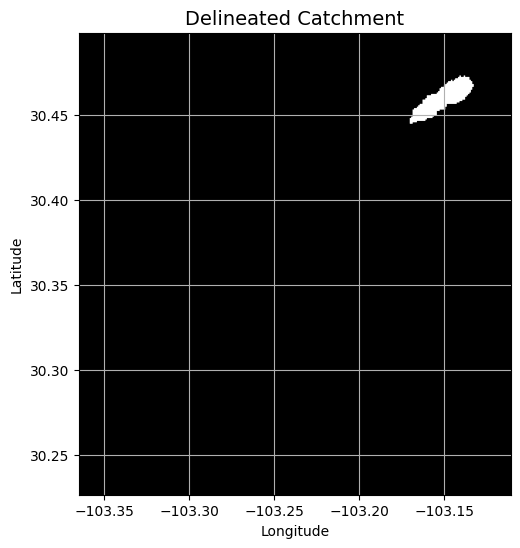

In [96]:
catch = find_watershed(grid, -103.1396995909179, 30.469989267888447)
# catch = find_watershed(grid, -103.2696995909179, 30.469989267888447)
# catch = find_watershed(grid, -103.17163916371383, 30.371938753553273)
# catch = find_watershed(grid, -103.17292662393481, 30.378158873572204)
print(catch)

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
# grid.clip_to(catch)
# clipped_catch = grid.view(catch)

# Plot the catchment
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.grid("on", zorder=0)
im = ax.imshow(
    catch,
    # np.where(clipped_catch, clipped_catch, np.nan),
    extent=grid.extent,
    zorder=1,
    cmap="Greys_r",
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Delineated Catchment", size=14)
plt.show()

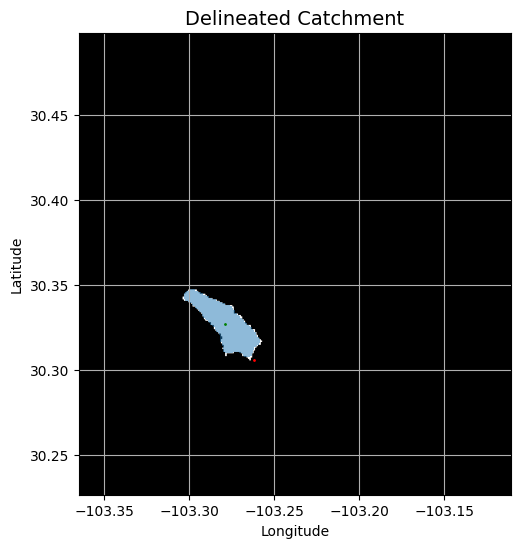

In [82]:
import rasterio
from PIL import Image, ImageFilter, ImageDraw
from shapely.geometry import Polygon
import numpy
import rasterio.features
img = Image.fromarray(catch)
# display(img)
# soften the edges
filtered_image = img.filter(ImageFilter.ModeFilter(size=4))

if filtered_image.getbbox():
    # if the image is not after applying the filter
    img = filtered_image

# display(img)

arr = numpy.uint8(img)
img = img.convert("RGB")
draw = ImageDraw.Draw(img)

# from shapely.geometry import Polygon
# import numpy
# arr = numpy.copy(catch).astype('uint8')
pargs = None
for p, s in rasterio.features.shapes(arr,
                                     transform=catch.affine
                                    ):
    if s == 1:
        pargs = p['coordinates']
        draw.polygon(p['coordinates'][0], fill ="#ff0000", outline ="blue")
    # plt.plot(*p.exterior.xy)
# plt.show()
# draw.polygon(((1, 10), (10, 20), (30, 40)), fill="#ff0000", outline ="blue")
# display(img)

polygon = Polygon(*pargs)
# print(polygon.centroid)
# draw.point((polygon.centroid.x, polygon.centroid.y) , (0, 0, 0))
# display(img)
        
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.grid("on", zorder=0)
im = ax.imshow(
    catch,
    # np.where(clipped_catch, clipped_catch, np.nan),
    extent=grid.extent,
    zorder=1,
    cmap="Greys_r",
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Delineated Catchment", size=14)
plt.plot(
    polygon.centroid.x, polygon.centroid.y, 'go', markersize=1,
)
plt.plot(
    *coords, 'ro', markersize=1,
)
plt.fill(*polygon.exterior.xy, alpha=0.5, ec='none')
plt.show()

In [95]:
import shapely
import json

print(json.loads(shapely.to_geojson(polygon)))

{'type': 'Polygon', 'coordinates': [[[-103.3, 30.3475], [-103.29666666666667, 30.3475], [-103.29666666666667, 30.346666666666668], [-103.295, 30.346666666666668], [-103.295, 30.345833333333335], [-103.29333333333332, 30.345833333333335], [-103.29333333333332, 30.345000000000002], [-103.29166666666666, 30.345000000000002], [-103.29166666666666, 30.34416666666667], [-103.28999999999999, 30.34416666666667], [-103.28999999999999, 30.343333333333334], [-103.28833333333333, 30.343333333333334], [-103.28833333333333, 30.3425], [-103.28666666666666, 30.3425], [-103.28666666666666, 30.34166666666667], [-103.28416666666666, 30.34166666666667], [-103.28416666666666, 30.340833333333336], [-103.2825, 30.340833333333336], [-103.2825, 30.34], [-103.28083333333333, 30.34], [-103.28083333333333, 30.339166666666667], [-103.27916666666667, 30.339166666666667], [-103.27916666666667, 30.338333333333335], [-103.27583333333332, 30.338333333333335], [-103.27583333333332, 30.337500000000002], [-103.27499999999

In [12]:
grid.shape

(235, 197)